In [1]:
import pandas as pd
import pandana as pdna
import time
import os
import json
import urllib
from shapely.geometry import Point, shape

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

In [2]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [3]:
city='Aalto'

Get the geographical bounds for the city and the feed for the city's GTFS data

In [4]:
bbox=(
        24.78,
        60.17,
        24.85,
        60.2
)

Download GFTS data

In [5]:
os.chdir('./'+city)

Load GTFS data into an UrbanAccess transit data object
The text files should be in data/gtfsfeed_text

In [6]:
validation = True
verbose = True
remove_stops_outsidebbox = True
append_definitions = True

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file header whitespace check completed. Took 24.74 seconds
--------------------------------
Processing GTFS feed: hsl
The unique agency id: helsingin_seudun_liikenne was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.36 seconds
Unique GTFS feed id operation complete. Took 0.08 seconds
Records: {}
      stop_id stop_code                 stop_name             stop_desc  \
0     1010102      2007               Ritarihuone            Mariankatu   
1     1010103      2008                Kirkkokatu         Mariankatu 13   
2     1010104      2009                Kirkkokatu         Mariankatu 12   
3     1010105      2010                 Vironkatu         Mariankatu 17   
4     1010106      2011                 Vironkatu         Mariankatu 20   
5     1010107      2014            Meritullinkatu          Liisankatu 8   
6     1010108      2013            Meritullinkatu         Liisankatu 11   
7     1010109      2016         

Appended route type to stops
Appended route type to stop_times
--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.44 seconds
1 GTFS feed file(s) successfully read as dataframes:
     hsl
     Took 43.95 seconds


Quickly view the transit stop locations

In [7]:
len(loaded_feeds.stops)

150

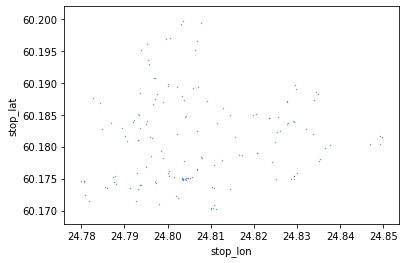

In [8]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

Create a travel time weighted graph for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period

In [9]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
762 service_ids were extracted from calendar
32,817 trip(s) 16.05 percent of 204,503 total trip records were found in calendar for GTFS feed(s): ['hsl']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
32,817 of 204,503 total trips were extracted representing calendar day: monday. Took 0.30 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 1.32 seconds
Stop times from 07:00:00 to 10:00:00 successfully selecte

Create a reference to the global network object called `urbanaccess_net`

In [10]:
urbanaccess_net = ua.network.ua_network

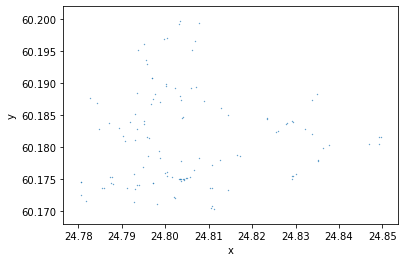

In [11]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

# Download OSM data

In [12]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](60.17000000,24.78000000,60.20000000,24.85000000);>;);out;'}"
Downloaded 0.7KB from www.overpass-api.de in 15.68 seconds
Server at www.overpass-api.de returned status code 429 and no JSON data. Re-trying request in 1.00 seconds.
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](60.17000000,24.78000000,60.20000000,24.85000000);>;);out;'}"
Downloaded 3,007.9KB from www.overpass-api.de in 3.10 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 20.18 seconds
Returning OSM dat

Create a travel time weighted graph from the pedestrian network - assume a pedestrian travels on average at 3 mph.
The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

In [13]:
remove_link_types=[
 'bridleway',
 'services',
 'steps',
 'footway',
 'cycleway',
 'service',
 'traffic_island',
 'unclassified',
 'track',
 'path'
]

In [14]:
edges=edges.loc[~edges['highway'].isin(remove_link_types)]
all_nodes_included=set(list(edges['from'].values)+list(edges['to'].values))
nodes=nodes.loc[nodes['id'].isin(all_nodes_included)]

In [15]:
nodes.to_csv('./data/osm_ped_network_nodes.csv', index=False)
edges.to_csv('./data/osm_ped_network_edges.csv', index=False)

In [16]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


In [17]:
urbanaccess_net.osm_nodes.head()

,x,y,id,net_type
id,,,,
130190,24.828787,60.187982,130190,walk
131938,24.838744,60.180260,131938,walk
131939,24.842913,60.180771,131939,walk
131940,24.846306,60.181195,131940,walk
131941,24.849017,60.181524,131941,walk


In [18]:
urbanaccess_net.osm_edges.head()

access area bridge   distance est_width       from  \
991667720 992438248    NaN  NaN    NaN  29.328063       NaN  991667720   
992438248 991667720    NaN  NaN    NaN  29.328063       NaN  992438248   
          25030680     NaN  NaN    NaN  32.586504       NaN  992438248   
25030680  992438248    NaN  NaN    NaN  32.586504       NaN   25030680   
25031706  25199769     NaN  NaN    NaN  11.290353       NaN   25031706   

                         highway junction lanes maxspeed               name  \
991667720 992438248  residential      NaN   NaN       40  Servin Maijan tie   
992438248 991667720  residential      NaN   NaN       40  Servin Maijan tie   
          25030680   residential      NaN   NaN       40  Servin Maijan tie   
25030680  992438248  residential      NaN   NaN       40  Servin Maijan tie   
25031706  25199769   residential      NaN     1       40           Otaranta   

                    oneway  ref service         to tunnel width    weight  \
991667720 992438248    NaN  NaN     NaN  992438248    NaN   NaN  0.364473   
992438248 991667720    NaN  NaN     NaN  991667720    NaN   NaN  0.364473   
          25030680     NaN  NaN     NaN   25030680    NaN   NaN  0.404967   
25030680  992438248    NaN  NaN     NaN  992438248    NaN   NaN  0.404967   
25031706  25199769     yes  NaN     NaN   25199769    NaN   NaN  0.140310   

                    net_type  
991667720 992438248     walk  
992438248 991667720     walk  
          25030680      walk  
25030680  992438248     walk  
25031706  25199769      walk

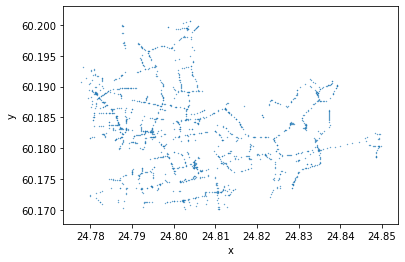

In [19]:
urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

Add average transit headways

In [20]:
# Not using the headways
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 122 nodes and 3,979 edges;
     OSM: 1,636 nodes and 3,454 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 0.13 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 0.12 seconds
Network edge and node network integration completed successfully resulting in a total of 1,758 nodes and 7,677 edges:
     Transit: 122 nodes 3,979 edges;
     OSM: 1,636 nodes 3,454 edges; and
     OSM/Transit connector: 244 edges.


# Create an integrated transit and pedestrian network

In [21]:
urbanaccess_net.net_nodes.head()

,id,location_type,net_type,parent_station,route_type,stop_code,stop_id,stop_name,unique_agency_id,wheelchair_boarding,x,y,zone_id
id_int,,,,,,,,,,,,,
1,1303102_helsingin_seudun_liikenne,0.0,transit,,704.0,1489,1303102,Lehtisaarentie,helsingin_seudun_liikenne,0.0,24.849300,60.180400,A
2,1303111_helsingin_seudun_liikenne,0.0,transit,,704.0,1490,1303111,Lehdesniityntie,helsingin_seudun_liikenne,0.0,24.846967,60.180475,A
3,1303298_helsingin_seudun_liikenne,0.0,transit,,701.0,1415,1303298,Lehtisaarentie,helsingin_seudun_liikenne,2.0,24.849300,60.181600,A
4,1303114_helsingin_seudun_liikenne,0.0,transit,,701.0,1414,1303114,Lehtisaarentie,helsingin_seudun_liikenne,0.0,24.849633,60.181530,A
5,2122214_helsingin_seudun_liikenne,0.0,transit,,701.0,E1213,2122214,Makslahdentie,helsingin_seudun_liikenne,0.0,24.803490,60.199690,B


In [22]:
urbanaccess_net.net_edges.head()

,access,area,bridge,distance,est_width,from,highway,edge_id,junction,lanes,...,service,to,tunnel,unique_agency_id,unique_route_id,unique_trip_id,weight,width,from_int,to_int
0,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_1_0804_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_1_0804_helsingin_seudun_liikenne,1.0,nan,1,2
1,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_1_0941_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_1_0941_helsingin_seudun_liikenne,0.0,nan,1,2
2,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0724_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0724_helsingin_seudun_liikenne,0.0,nan,1,2
3,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0729_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0729_helsingin_seudun_liikenne,0.0,nan,1,2
4,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0824_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0824_helsingin_seudun_liikenne,0.0,nan,1,2


In [23]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

,access,area,bridge,distance,est_width,from,highway,edge_id,junction,lanes,...,service,to,tunnel,unique_agency_id,unique_route_id,unique_trip_id,weight,width,from_int,to_int
0,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_1_0804_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_1_0804_helsingin_seudun_liikenne,1.0,nan,1,2
1,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_1_0941_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_1_0941_helsingin_seudun_liikenne,0.0,nan,1,2
2,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0724_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0724_helsingin_seudun_liikenne,0.0,nan,1,2
3,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0729_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0729_helsingin_seudun_liikenne,0.0,nan,1,2
4,nan,nan,nan,NaN,nan,1303102_helsingin_seudun_liikenne,nan,1034_20200128_Ma_2_0824_helsingin_seudun_liike...,nan,nan,...,nan,1303111_helsingin_seudun_liikenne,nan,helsingin_seudun_liikenne,1034_helsingin_seudun_liikenne,1034_20200128_Ma_2_0824_helsingin_seudun_liikenne,0.0,nan,1,2


Plot the combined network

In [24]:
edgecolor_weight = ua.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)

In [25]:
edgecolor_type=list(urbanaccess_net.net_edges.apply(lambda row: (1,0,0,1) if row['net_type']=='transit' else (127/255,201/255,127/255, 1), axis=1))

Plot by link type

Figure created. Took 1.77 seconds


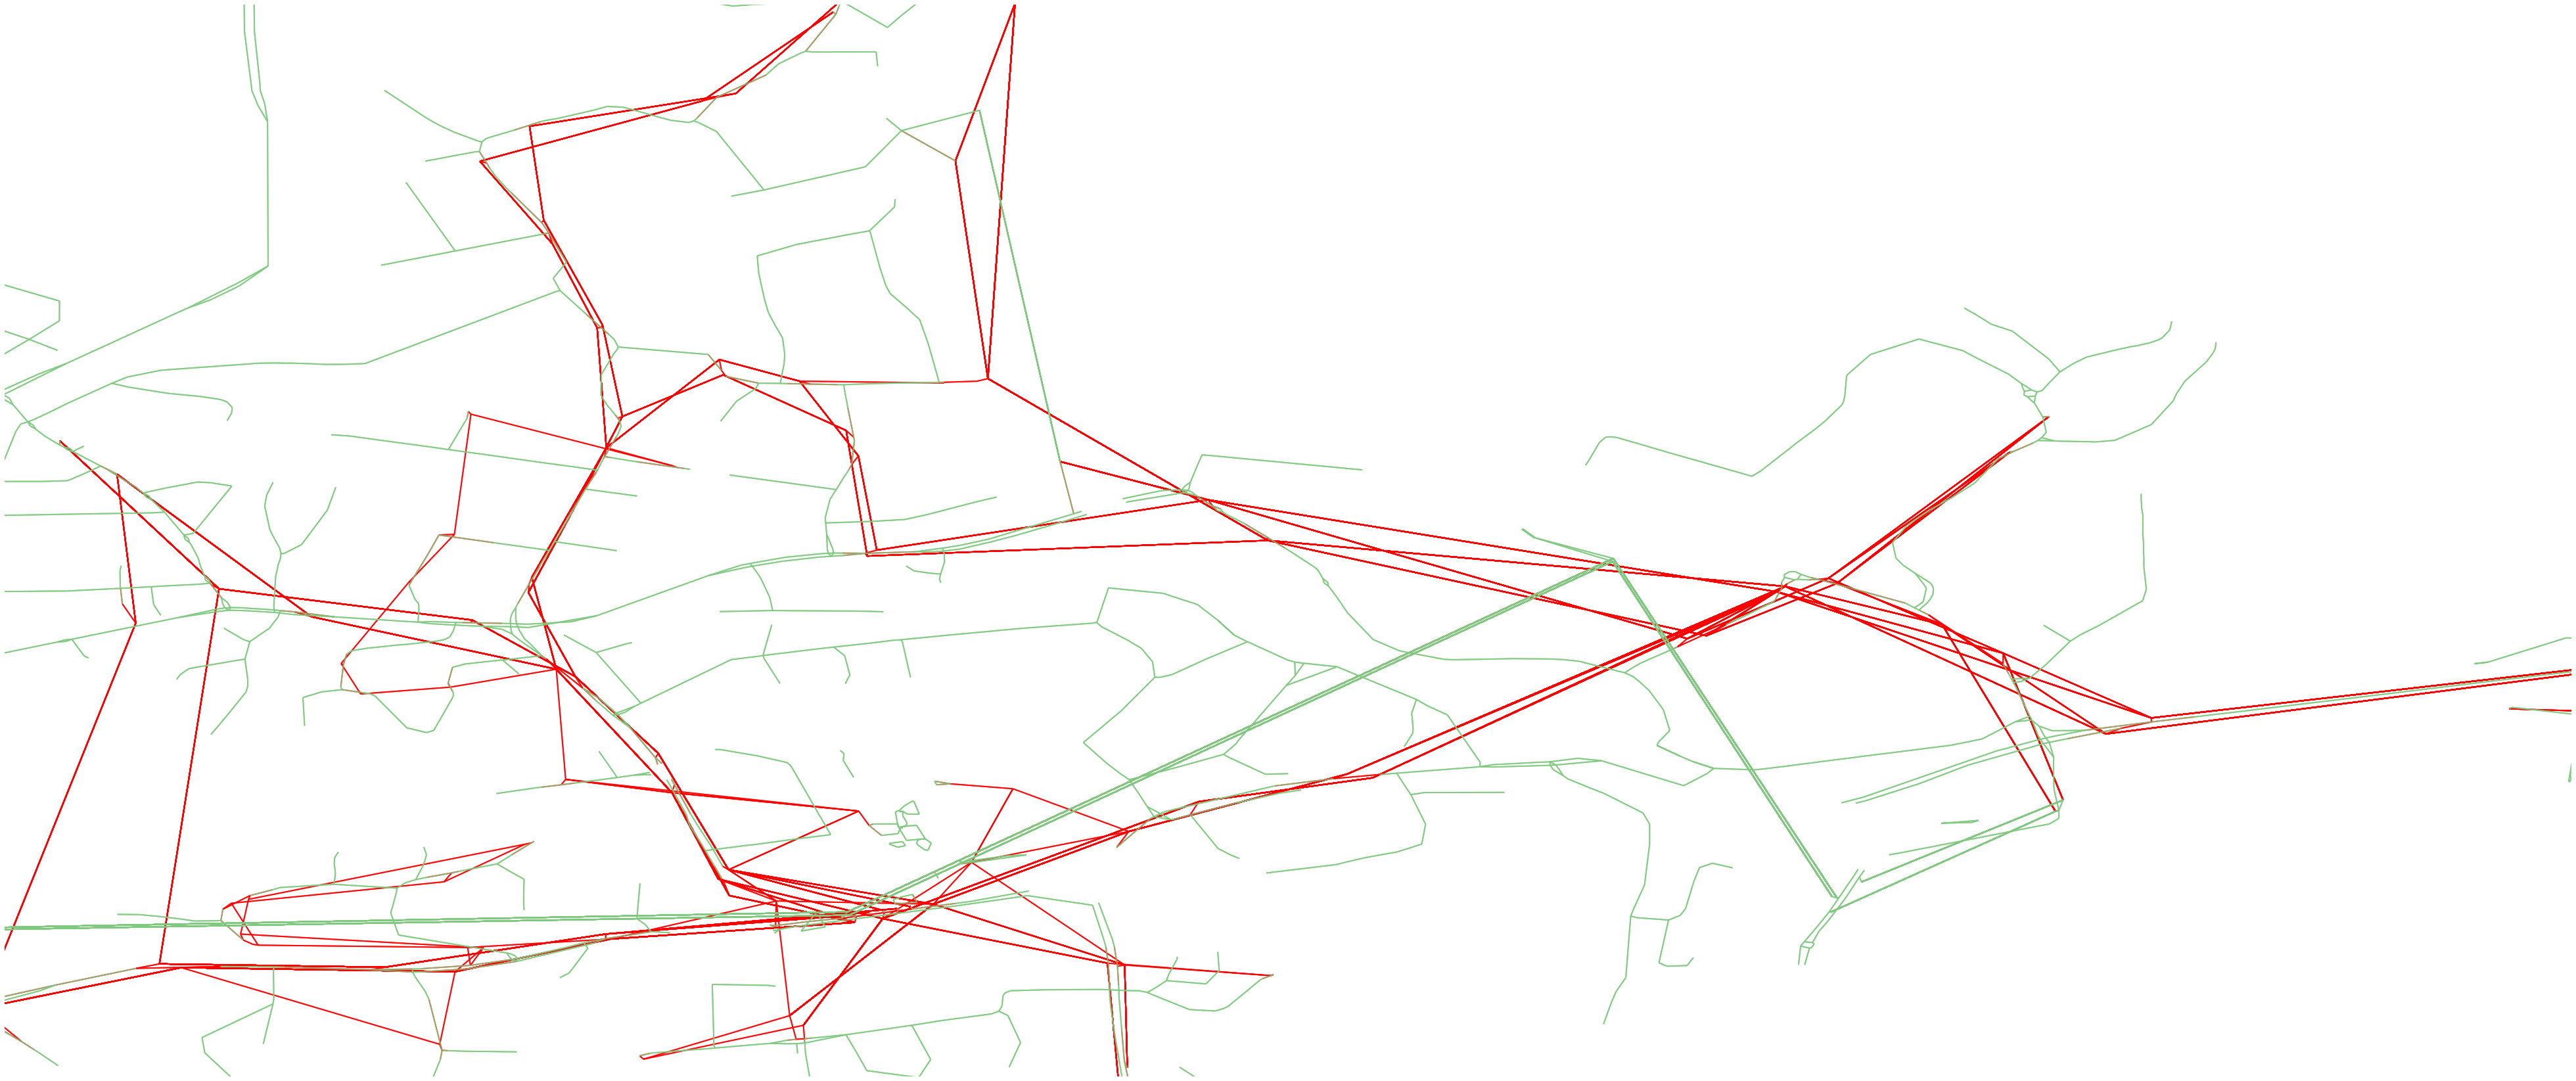

(<Figure size 5040x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1190ccf28>)

In [26]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_type, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Figure created. Took 3.39 seconds


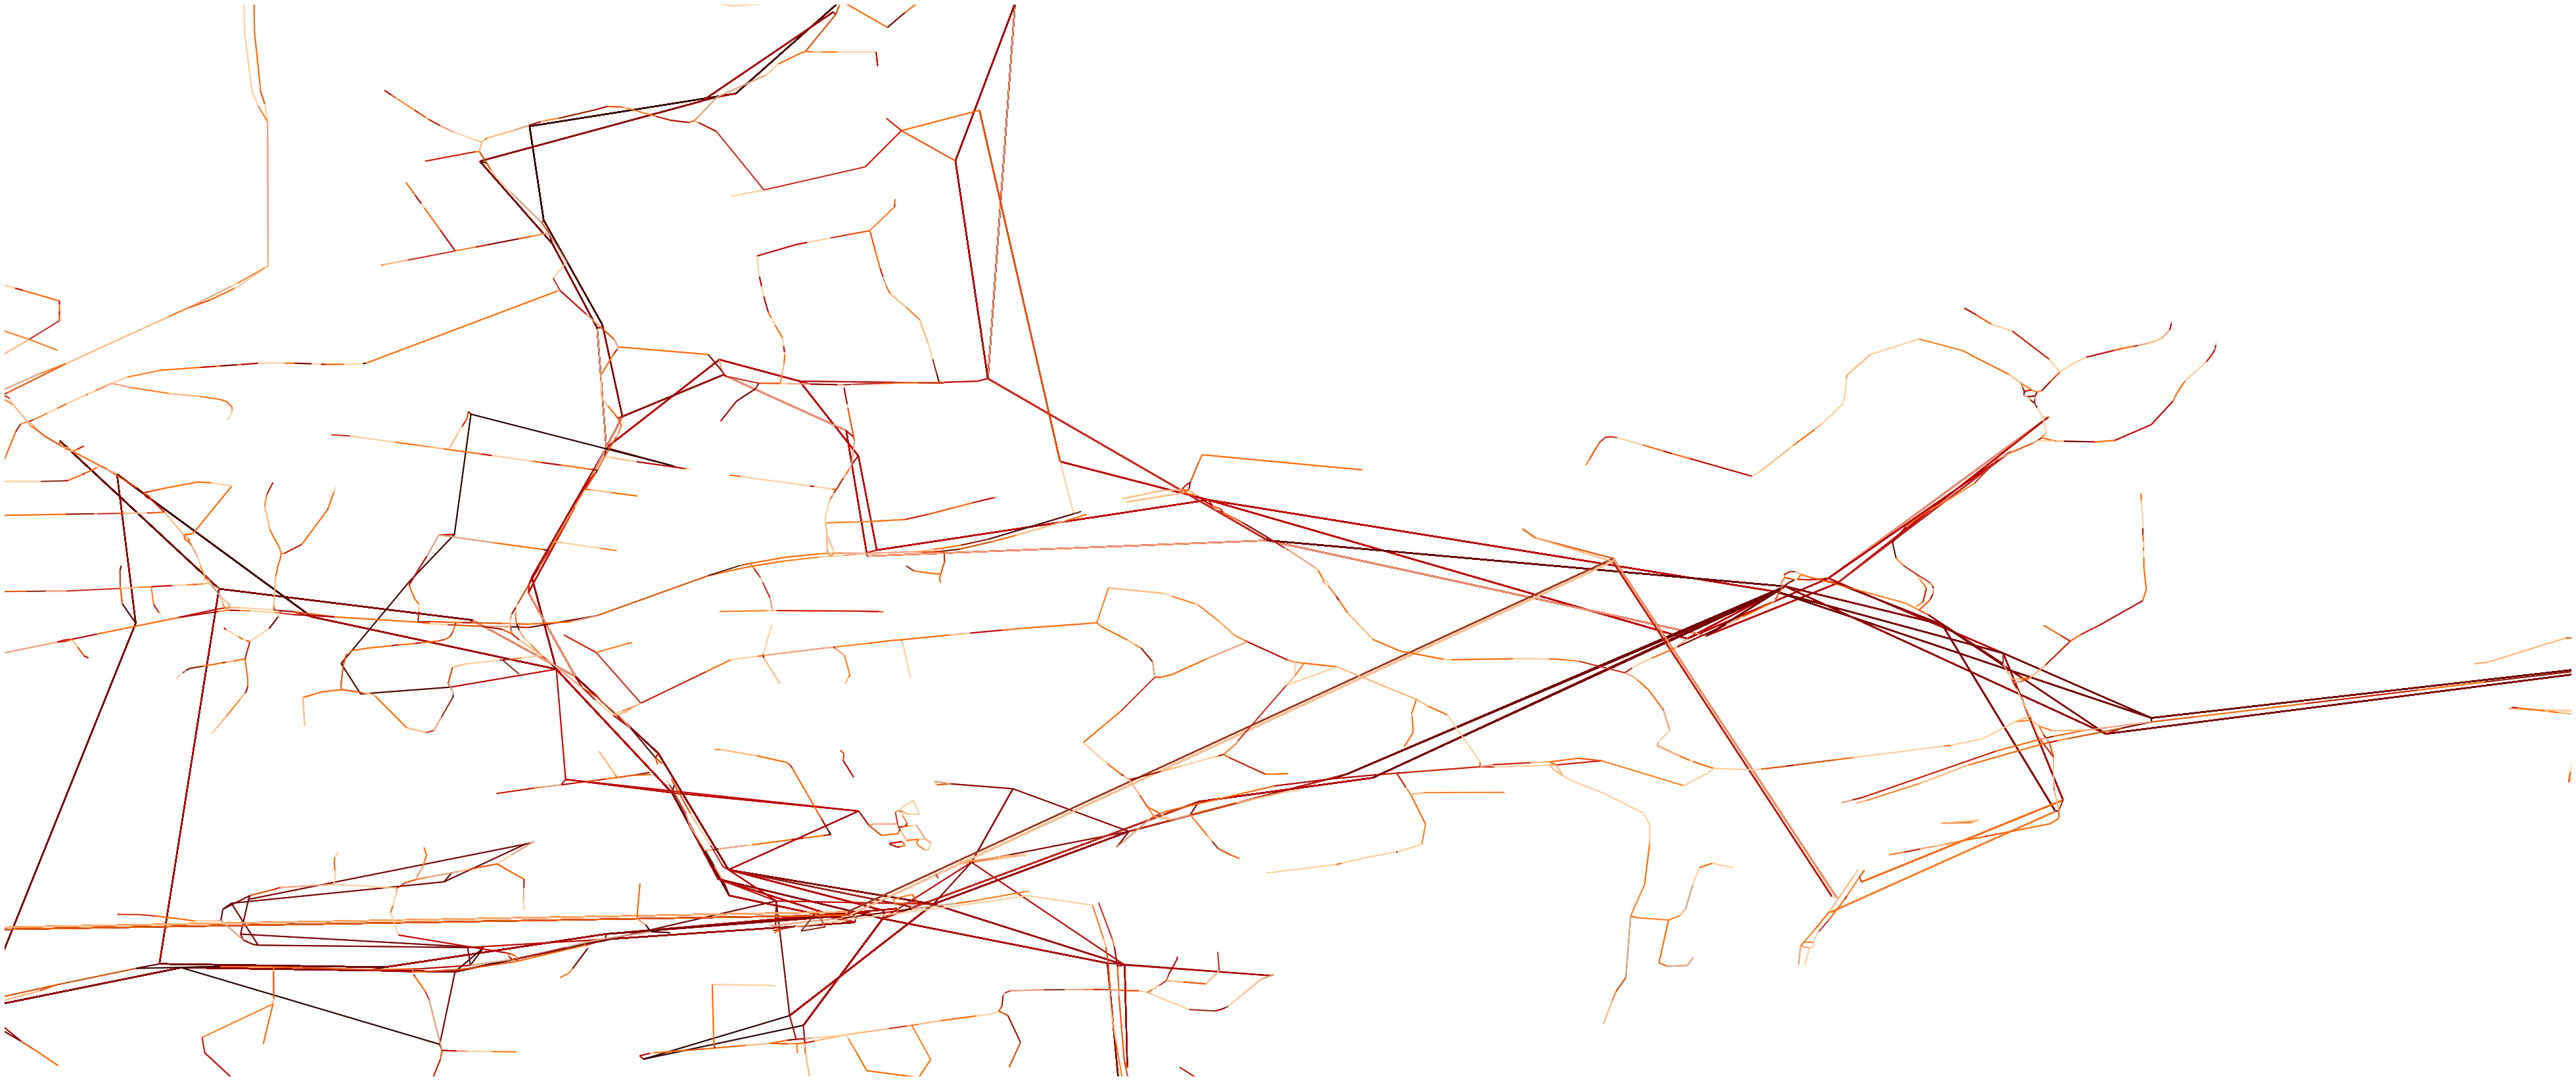

(<Figure size 5040x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1190cc400>)

In [27]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color=edgecolor_weight, edge_linewidth=2, edge_alpha=0.8,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

Save the combined network as csv

In [28]:
urbanaccess_net.net_nodes.to_csv('./data/comb_network_nodes.csv')
urbanaccess_net.net_edges.to_csv('./data/comb_network_edges.csv')